In [ ]:
#https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

## load data

In [77]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
mpl.style.use('mg')
%run "./t04_nn_script.ipynb"

In [78]:
path='/Users/mgao1/OneDrive - NASA/data/mapol_test1/test002_simulator/'
#file='input_test_t101_output.h5'
file='input_test_t101_n1000_output.h5'
filename=path+file

f=h5py.File(filename,'r')
stokesv2=f['/AOP/Stokes'][()]
theta=f['/AOP/zen'][()]
phi=f['/AOP/az'][()]

solzen=f['/AOP/solzen'][()]*180/np.pi
aod=f['/parameters/AOD'][()]
pfr=f['/parameters/pfr'][()][:2,:]
pfi=f['/parameters/pfi'][()][:2,:]
pcr=f['/parameters/pcr'][()][:2,:]
pci=f['/parameters/pci'][()][:2,:]
vdv=f['/parameters/vdv'][()]
wndspd=f['/parameters/wndspd'][()]
chla=f['/parameters/chla'][()]


refff=f['/parameters/refff'][()]
reffc=f['/parameters/reffc'][()]
vefff=f['/parameters/vefff'][()]
veffc=f['/parameters/veffc'][()]
mfr=f['/parameters/mfr'][()].flatten()
mfi=f['/parameters/mfi'][()].flatten()

print(theta.shape, phi.shape, stokesv2.shape,vdv.shape, mfr.shape, pfr.shape)

(81,) (91,) (3, 91, 81, 1000) (5, 1000) (1000,) (2, 1000)


solzen:15.07, wind:5.76, aod:0.19, chla:0.0748


<IPython.core.display.Javascript object>


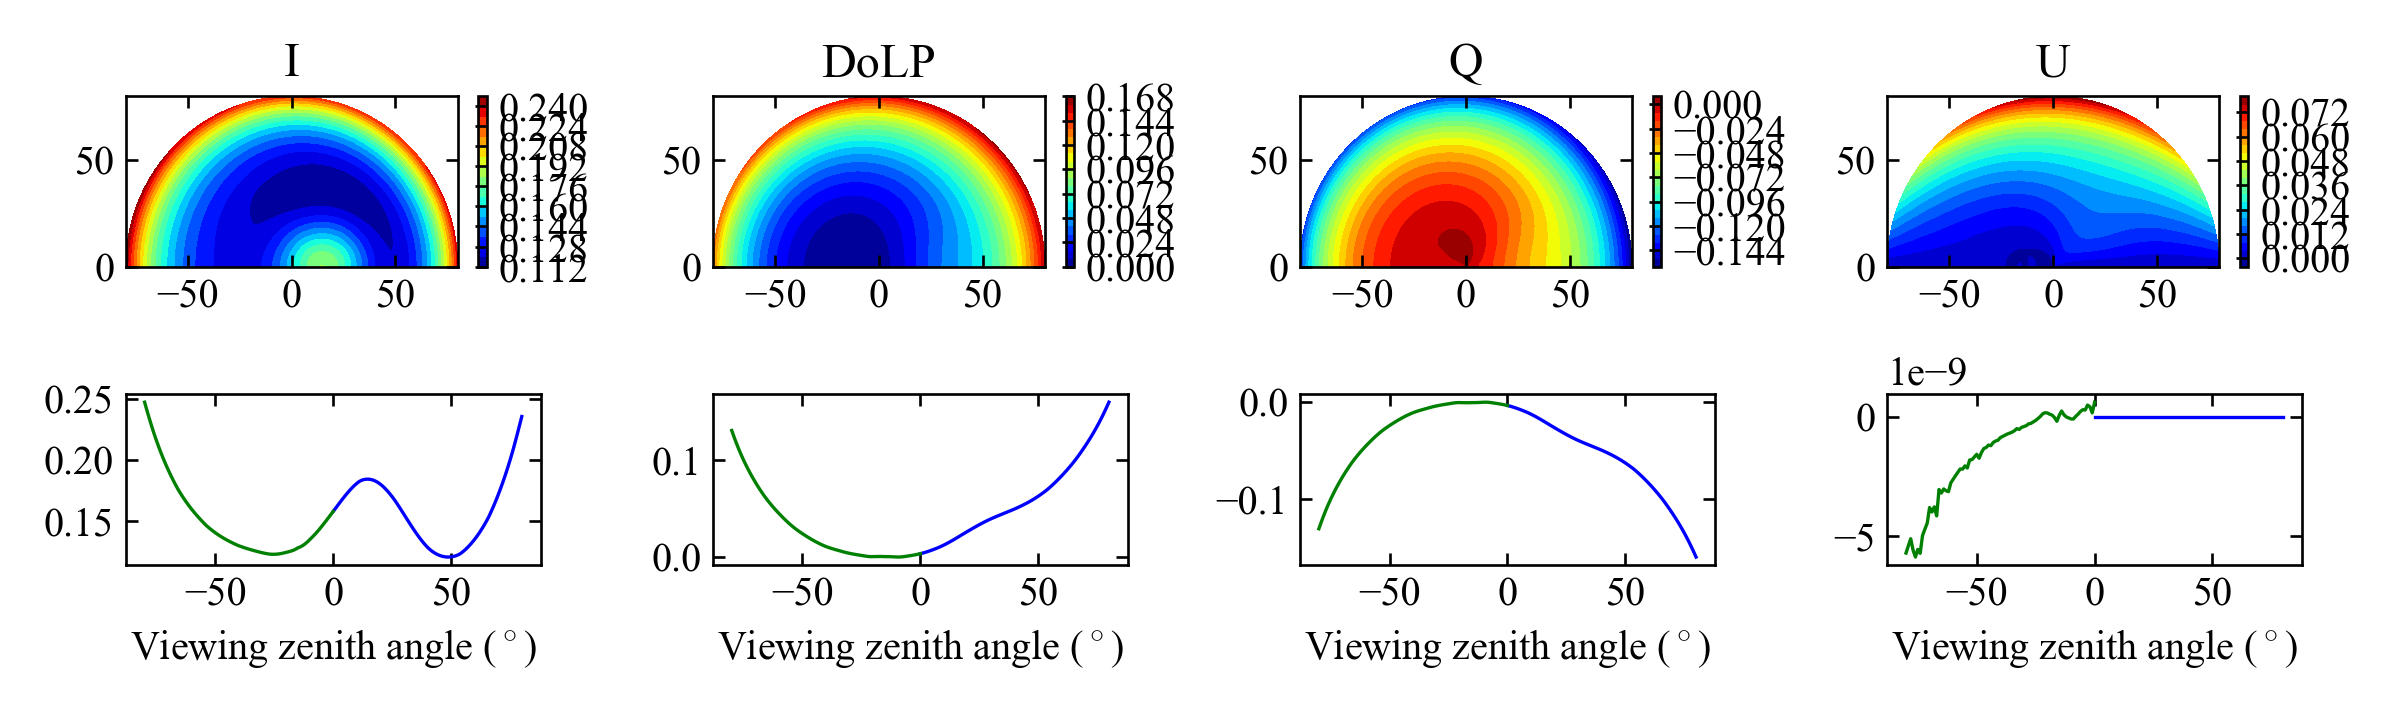

In [79]:
id1=1
print_par()
stokesv=stokesv2[:,:,:,id1]
outfile='/Users/mgao1/Desktop/stokes.pdf'
plot_stokesv(theta, phi, stokesv, outfile)

<IPython.core.display.Javascript object>


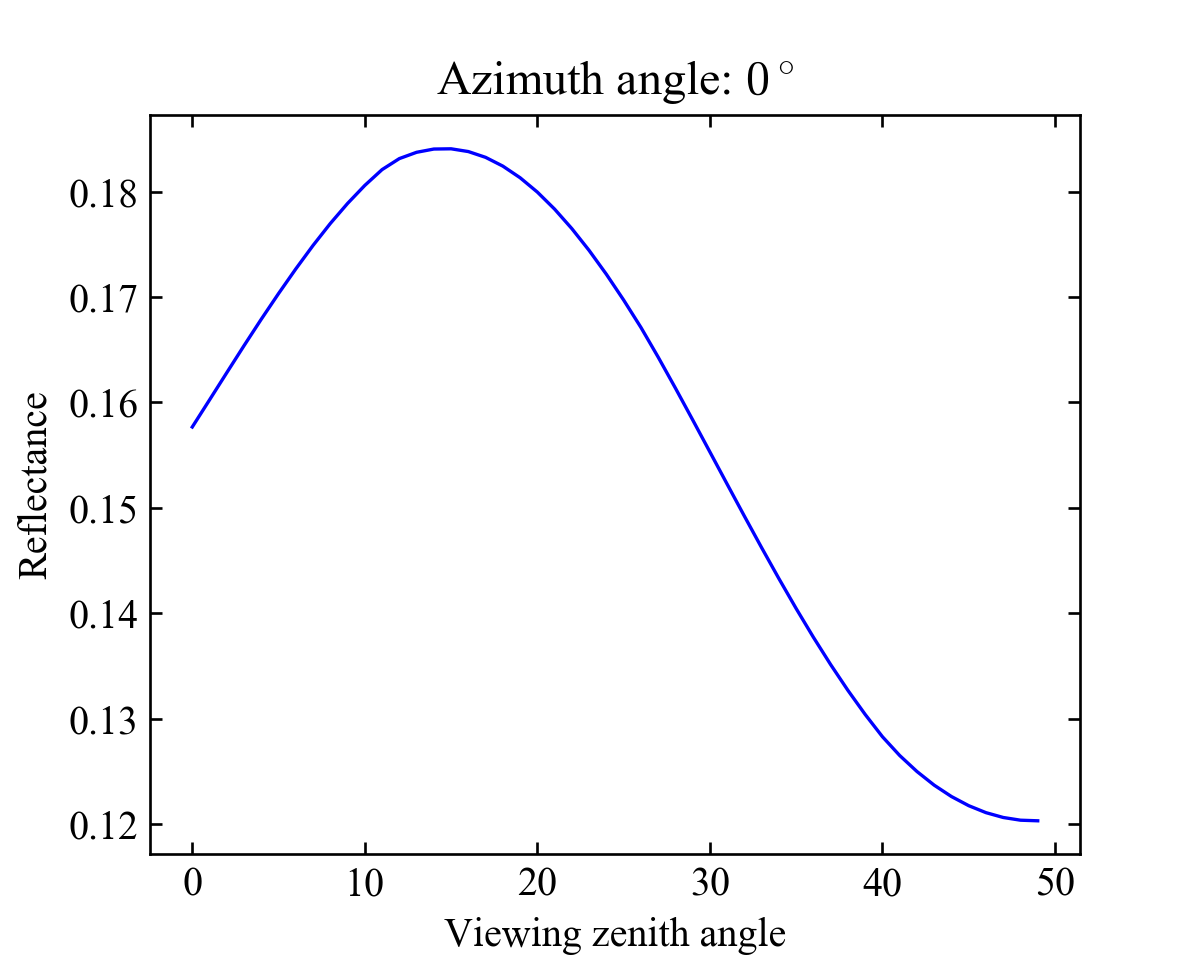

In [91]:
fig=plt.figure(figsize=(5,4))
plt.title("Azimuth angle: $0^\circ$")

plt.plot(stokesv[0,0,:50])
plt.xlabel("Viewing zenith angle")
plt.ylabel("Reflectance")
plt.show()

301


<IPython.core.display.Javascript object>


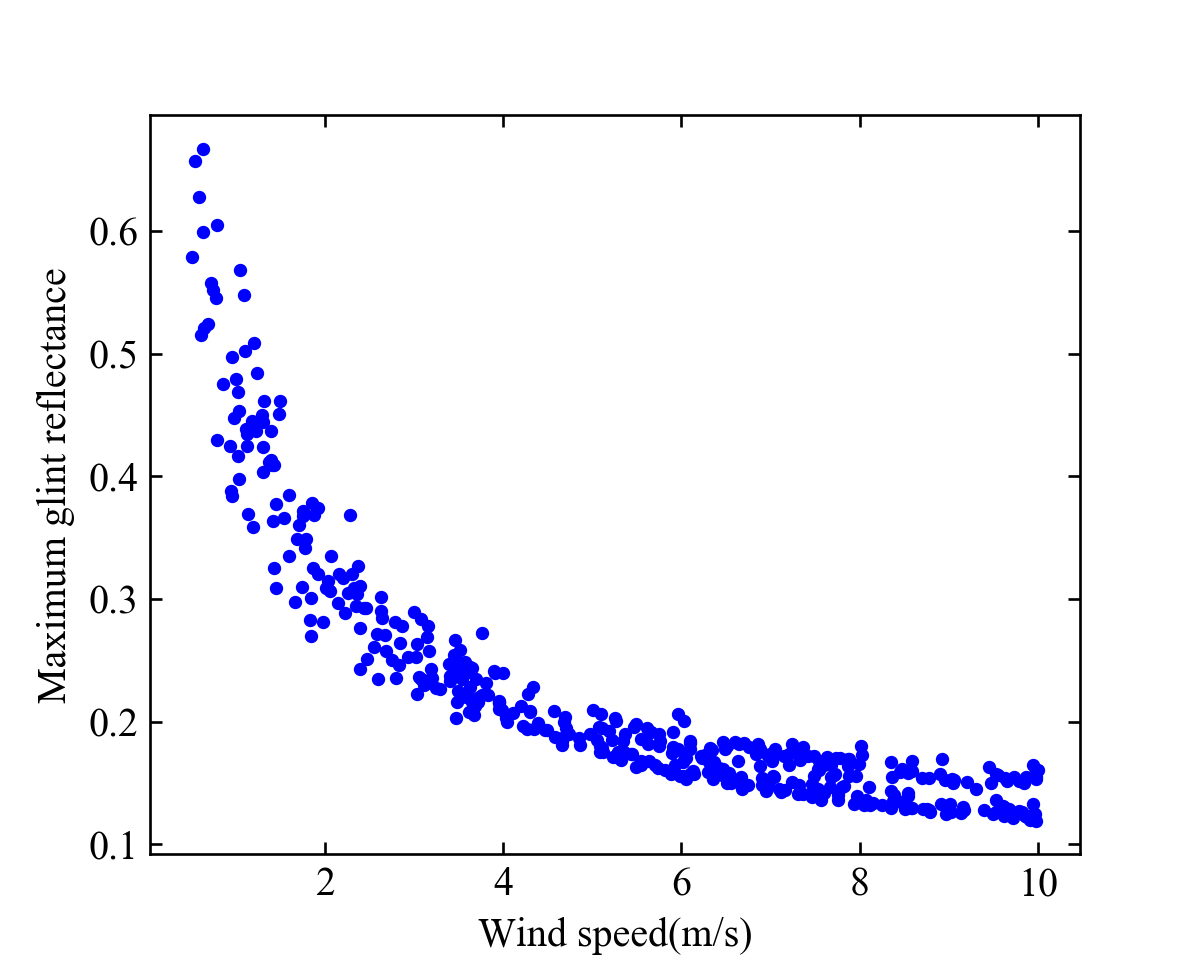

In [173]:
##################
maxang=30
dat1=np.array([stokesv2[0,0,:50,i].max() for i in range(len(stokesv2[0,0,0]))])
x1=wndspd[solzen<maxang]
y1=dat1[solzen<maxang]
nt=np.int32(0.7*len(x1))
print(nt)
x1train=x1[:nt]
y1train=y1[:nt]
x1test=x1[nt:]
y1test=y1[nt:]

#################
plt.figure(figsize=(5,4))
plt.plot(wndspd[solzen<maxang],dat1[solzen<maxang],'b.')
plt.xlabel("Wind speed(m/s)")
plt.ylabel("Maximum glint reflectance")
plt.show()

## Fitting maximum glint reflectance with wind speed

In [174]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
#import imageio

## single-varaible linear regression

In [175]:
# torch can only train on Variable, so convert them to Variable
x=torch.from_numpy(x1train.reshape(len(x1train),1)) #one feature
y=torch.from_numpy(y1train.reshape(len(y1train),1)) #one output

xt=torch.from_numpy(x1test.reshape(len(x1test),1)) #one feature
yt=torch.from_numpy(y1test.reshape(len(y1test),1)) #one output
print(type(x),x.shape)
x, y=Variable(x).float(),Variable(y).float()
xt, yt=Variable(xt).float(),Variable(yt).float()
print(type(x),x.shape)
print(type(xt),xt.shape)

<class 'torch.Tensor'> torch.Size([301, 1])
<class 'torch.Tensor'> torch.Size([301, 1])
<class 'torch.Tensor'> torch.Size([130, 1])


<IPython.core.display.Javascript object>


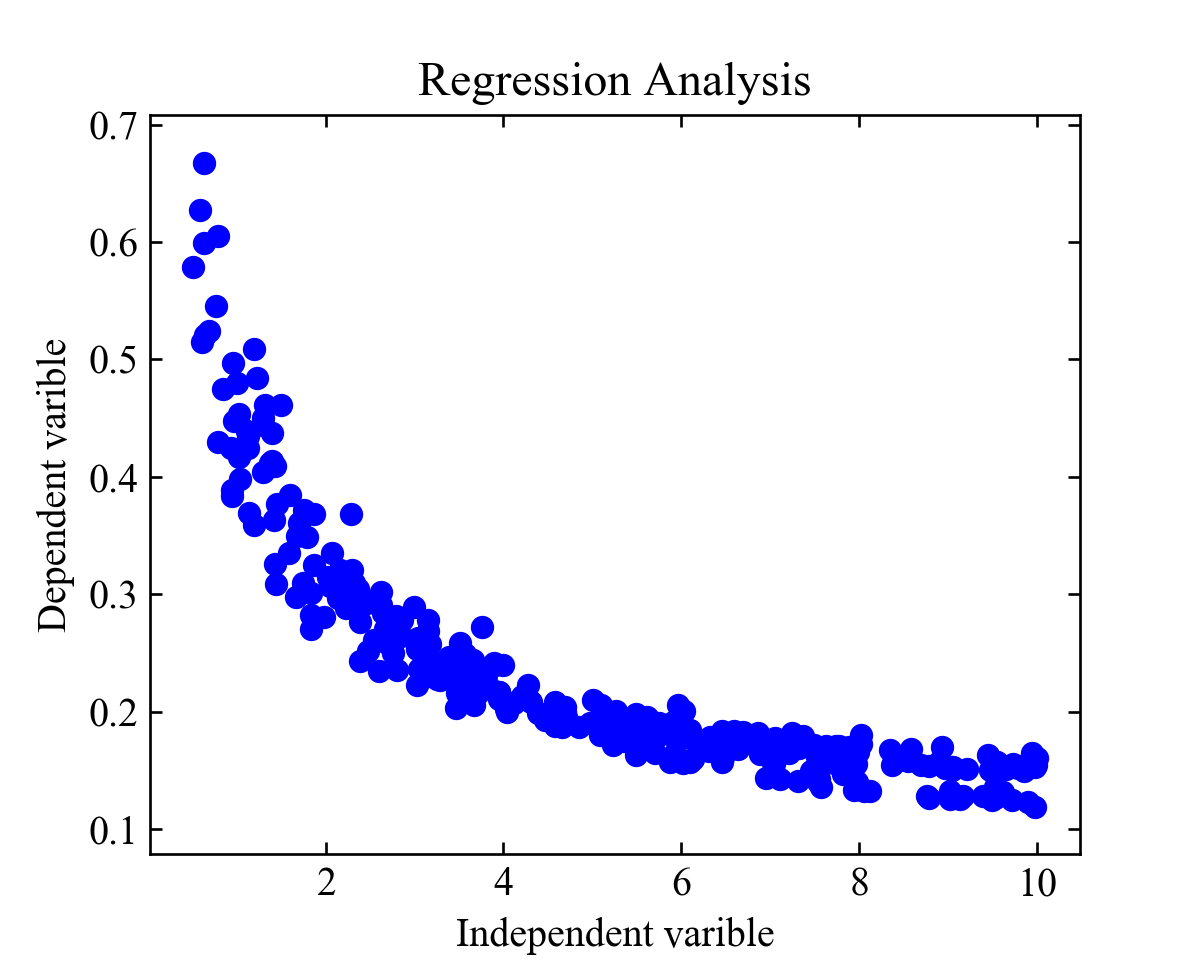

In [176]:
# view data
plt.figure(figsize=(5,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "b")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

In [197]:
import copy #weight need deepcopy 
#import torch
#from torch.autograd import Variable
class Net0(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net0, self).__init__()
        self.linear = torch.nn.Linear(n_feature, n_output)

    def forward(self, x):
        x = self.linear(x)
        return x

    
def train(ax, net, learning_rate, iterations, x, y, xt, yt, nplot):
    # print(net)  # net architecture
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    #optimizer = torch.optim.RMSprop(net.parameters())
    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

    lossv=[]
    lossvt=[]
    weightsv=[]
    # train the network
    
    

    for t in range(iterations): #500 is not enough
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        
        #testing 
        predictiont=net(xt)
        losst=loss_func(predictiont, yt) 
        ################################

        lossv.append(loss.data.numpy())
        lossvt.append(losst.data.numpy())
        weights=[]
        for param in net.parameters():
            weights.append(copy.deepcopy(param.data.numpy()))
        #print(weights)
        weightsv.append(weights)
        #print(weightsv[t])
        if t % np.int(iterations/nplot)== np.int(iterations/nplot)-1:
            ax.plot(x.data.numpy(), prediction.data.numpy(), 'g.', lw=0.1)
            print(t, loss.item(),losst.item())#, weights[0][0],weights[0][0], weightsv[t][0][0])
        ################################

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    #print(weightsv)       
    #lossv=np.array(lossv)
    #weightsv=np.array(weightsv)
    
    return prediction, weightsv, lossv, lossvt
def to_array(list1):
    return np.array([list1[t] for t in range(len(list1))])
def to_array2d(list1,i):
    return np.array([list1[t][i][0] for t in range(len(list1))])
def init_weights(m):
    if type(m) == torch.nn.Linear:
        #torch.nn.init.xavier_uniform_(m.weight)
        #m.bias.data.fill_(0.01)
        #torch.nn.init.constant_(m.weight,1)
        
        m.weight.data.fill_(1.0)
        m.bias.data.fill_(0.0)

In [178]:
net = Net0(n_feature=1,n_output=1)     # define the network
net.apply(init_weights)
weights=[]
for param in net.parameters():
    print(param.data.numpy().shape,param.data.numpy())
    
    weights.append(param.data.numpy())

(1, 1) [[1.]]
(1,) [0.]


In [179]:
net.linear.weight, net.linear.bias

(Parameter containing:
 tensor([[1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True))

In [180]:
weightsv[-1]

[array([[-1.0170597]], dtype=float32), array([0.24235398], dtype=float32)]

<IPython.core.display.Javascript object>


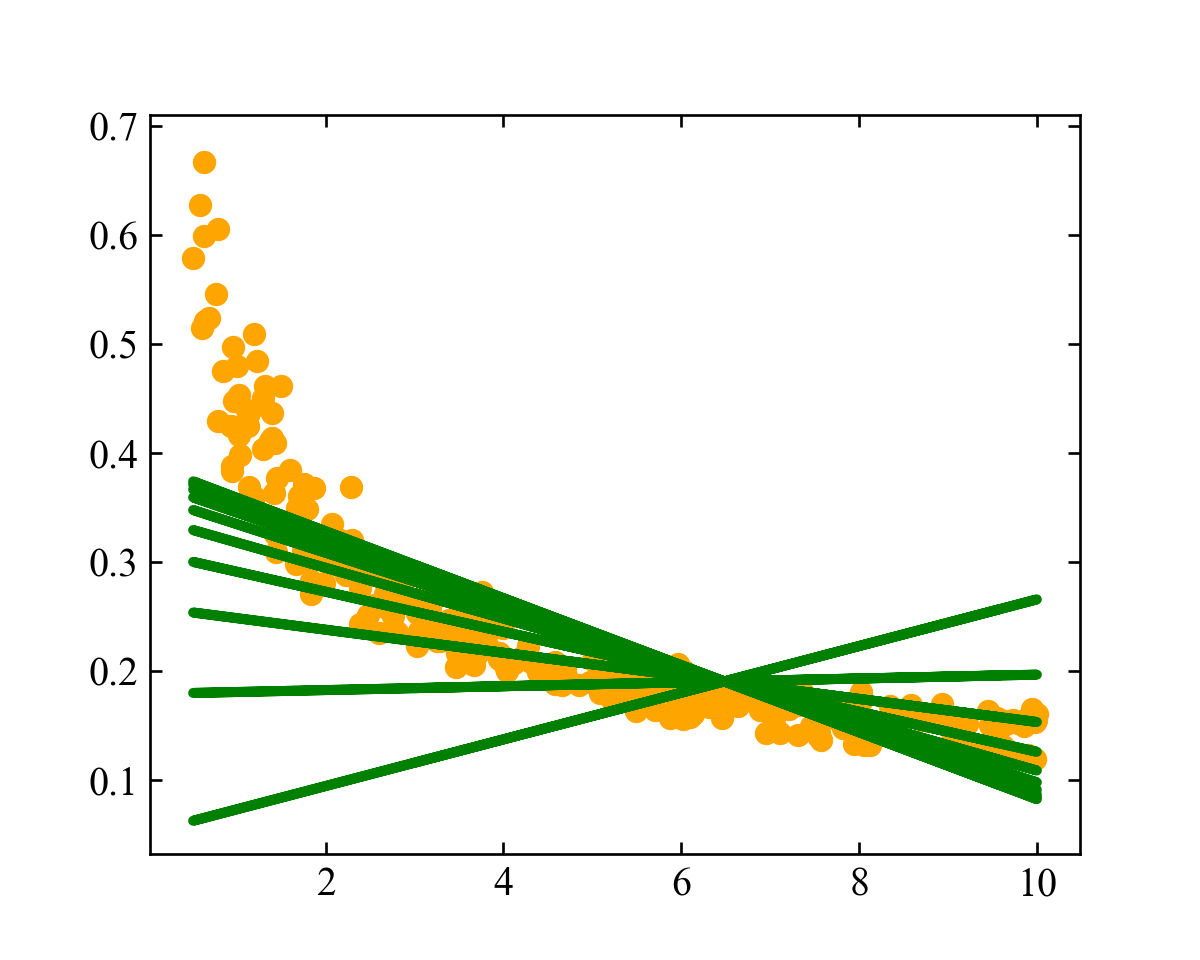

49 0.03127644211053848 0.027112606912851334
99 0.014432177878916264 0.013569545932114124
149 0.007764460518956184 0.007930666208267212
199 0.005125074181705713 0.005523679777979851
249 0.00408029044046998 0.004460874479264021
299 0.003666714997962117 0.003970947116613388
349 0.0035030043218284845 0.003733463818207383
399 0.003438199870288372 0.003612056840211153
449 0.0034125475212931633 0.0035467601846903563
499 0.0034023933112621307 0.0035100667737424374


<IPython.core.display.Javascript object>


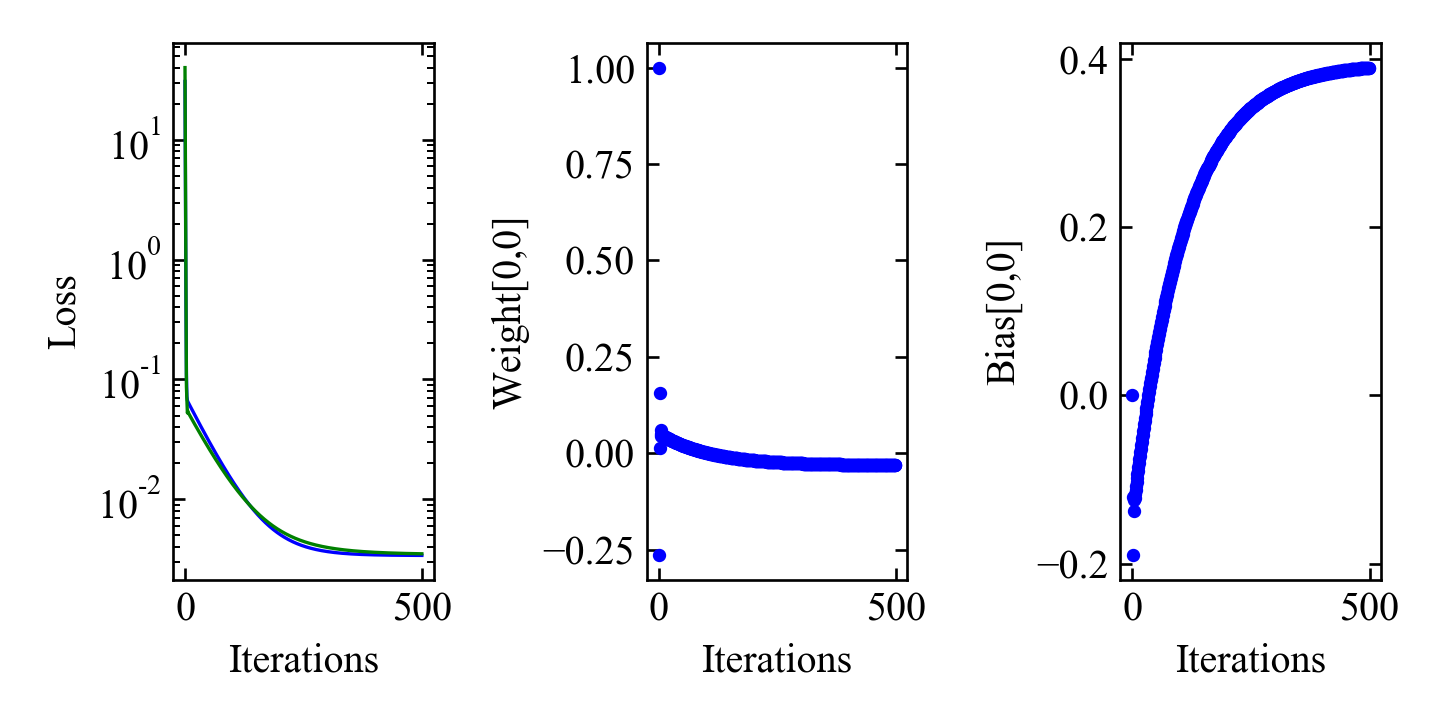

fitted parameters: [array([[-0.03076109]], dtype=float32), array([0.38959017], dtype=float32)]


In [181]:
learning_rate =0.02
iterations=500
nplot=10
net.apply(init_weights)

fig, ax = plt.subplots(figsize=(5,4))
#plt.cla()
ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
prediction, weightsv, lossv, lossvt=train(ax, net, learning_rate, iterations, x, y, xt, yt, nplot)

fig=plt.figure(figsize=(6,3))
ax=plt.subplot(131)
ax.set_yscale('log')
plt.plot(to_array(lossv))
plt.plot(to_array(lossvt))
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.subplot(132)

plt.plot(to_array2d(weightsv,0),'.')
plt.xlabel("Iterations")
plt.ylabel("Weight[0,0]")
plt.subplot(133)
plt.plot(to_array2d(weightsv,1),'.')
plt.ylabel("Bias[0,0]")
plt.xlabel("Iterations")

plt.tight_layout()
print("fitted parameters:", weightsv[-1]) 

<IPython.core.display.Javascript object>


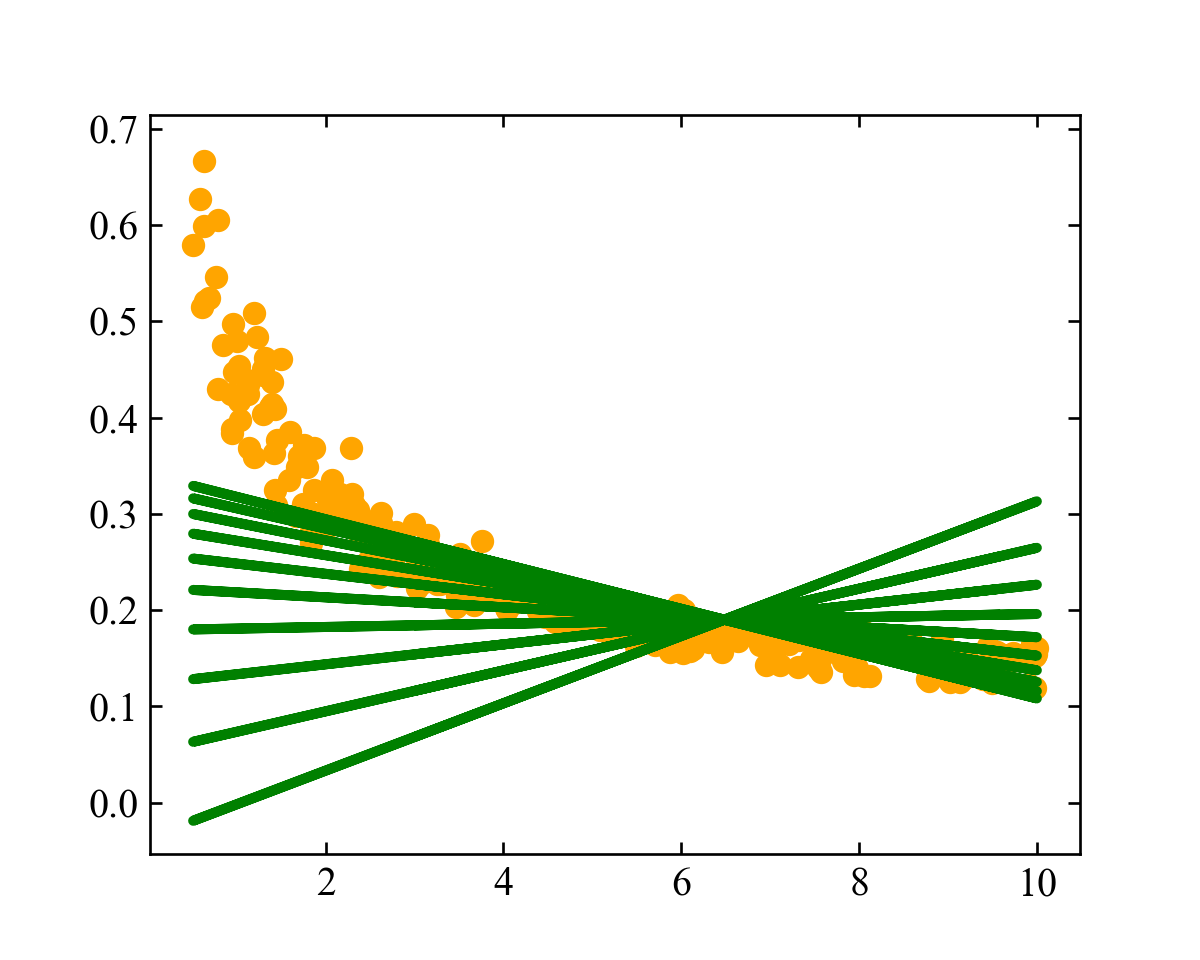

49 0.047347187995910645 0.039718128740787506
99 0.0310780368745327 0.02695566788315773
149 0.02083110436797142 0.018781056627631187
199 0.014377197250723839 0.013524188660085201
249 0.010312283411622047 0.010127352550625801
299 0.007752043195068836 0.007919752039015293
349 0.006139501929283142 0.006475239060819149
399 0.005123865325003862 0.005522513762116432
449 0.004484178964048624 0.004888390656560659
499 0.0040812804363667965 0.004461964126676321


<IPython.core.display.Javascript object>


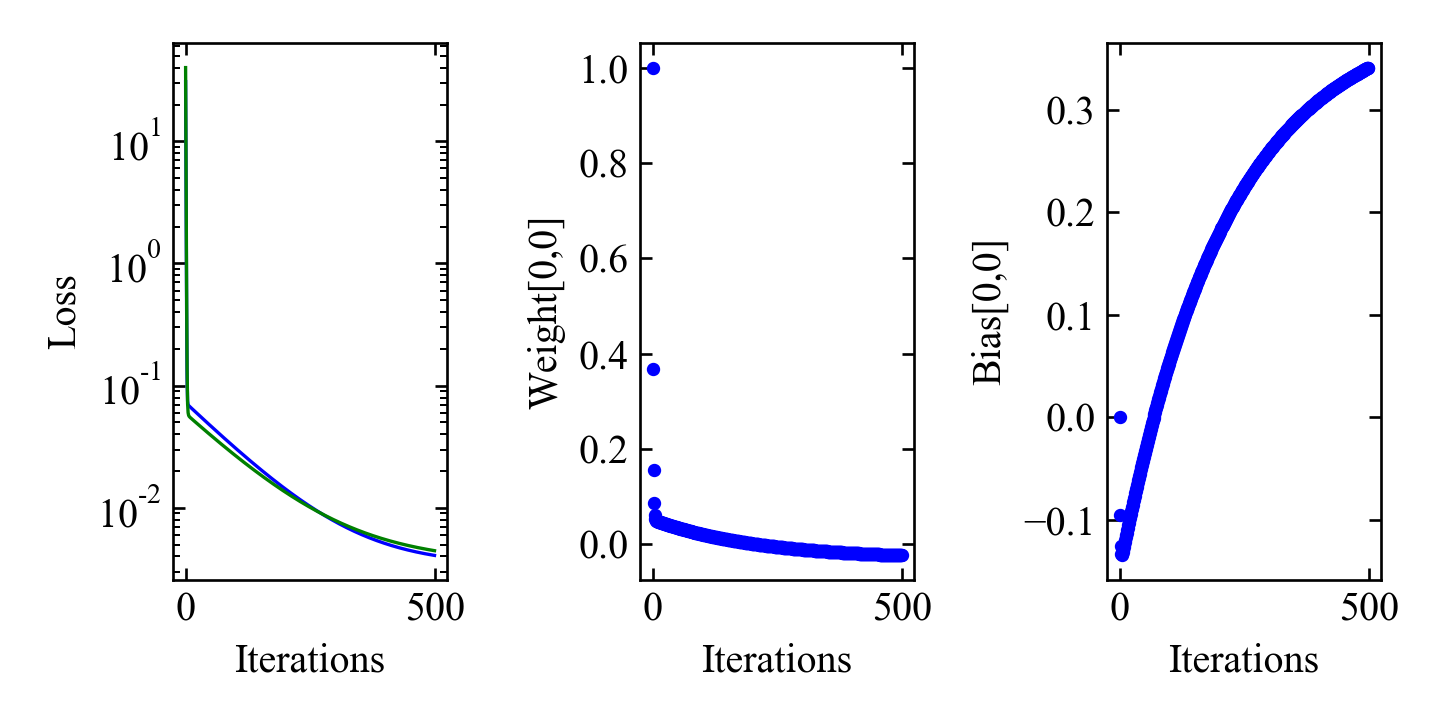

fitted parameters: [array([[-0.02326791]], dtype=float32), array([0.34101355], dtype=float32)]


In [182]:
learning_rate =0.01
iterations=500
nplot=10
net.apply(init_weights)

fig, ax = plt.subplots(figsize=(5,4))
#plt.cla()
ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
prediction, weightsv, lossv, lossvt=train(ax, net, learning_rate, iterations, x, y, xt, yt, nplot)

fig=plt.figure(figsize=(6,3))
ax=plt.subplot(131)
ax.set_yscale('log')
plt.plot(to_array(lossv))
plt.plot(to_array(lossvt))
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.subplot(132)

plt.plot(to_array2d(weightsv,0),'.')
plt.xlabel("Iterations")
plt.ylabel("Weight[0,0]")
plt.subplot(133)
plt.plot(to_array2d(weightsv,1),'.')
plt.ylabel("Bias[0,0]")
plt.xlabel("Iterations")

plt.tight_layout()
print("fitted parameters:", weightsv[-1]) 

<IPython.core.display.Javascript object>


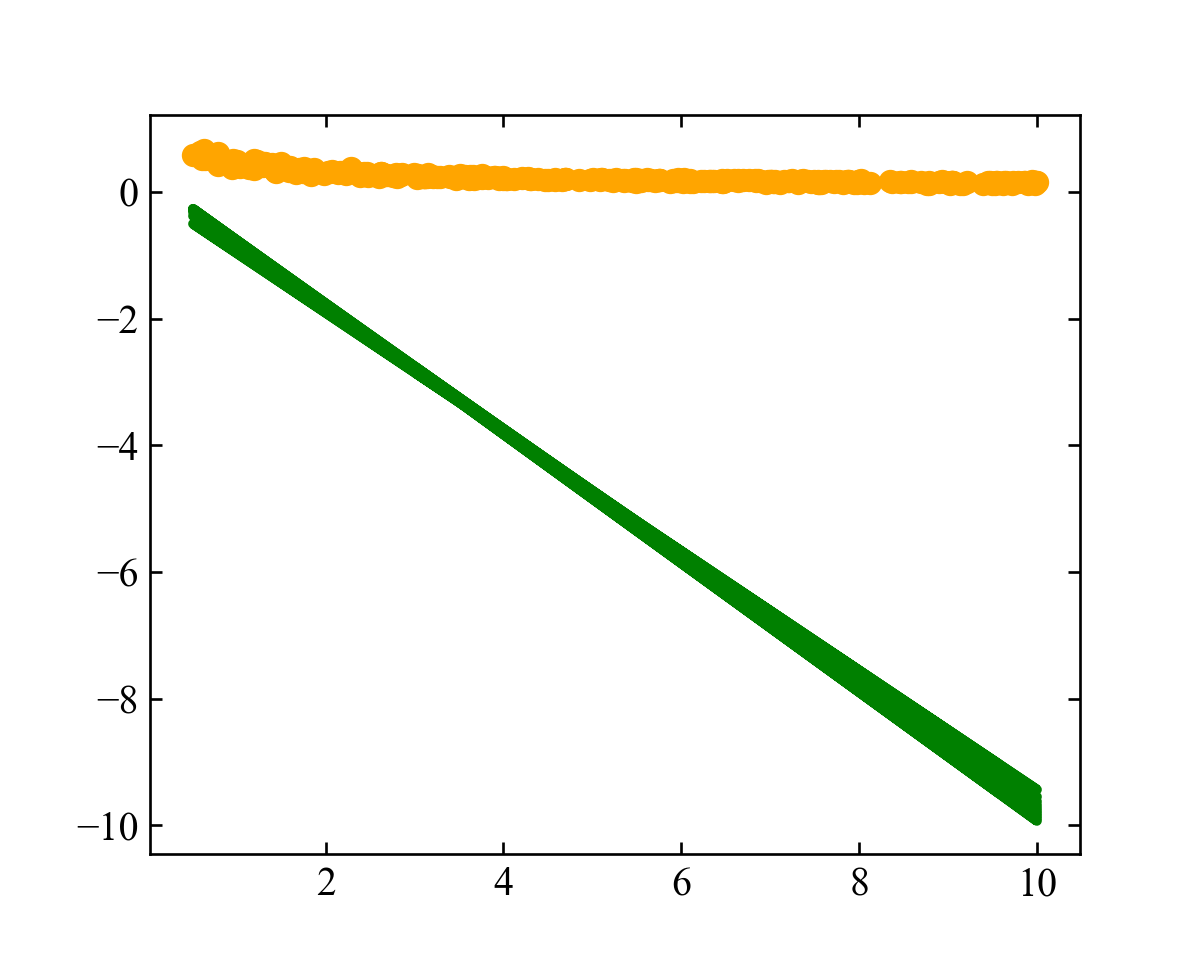

49 30.932971954345703 39.34453582763672
99 31.160640716552734 39.784217834472656
149 31.400190353393555 40.16352844238281
199 31.64406967163086 40.51194763183594
249 31.8903865814209 40.845619201660156
299 32.13887023925781 41.1732063293457
349 32.38941955566406 41.49903106689453
399 32.64170455932617 41.824886322021484
449 32.896209716796875 42.152488708496094
499 33.152679443359375 42.4820671081543


<IPython.core.display.Javascript object>


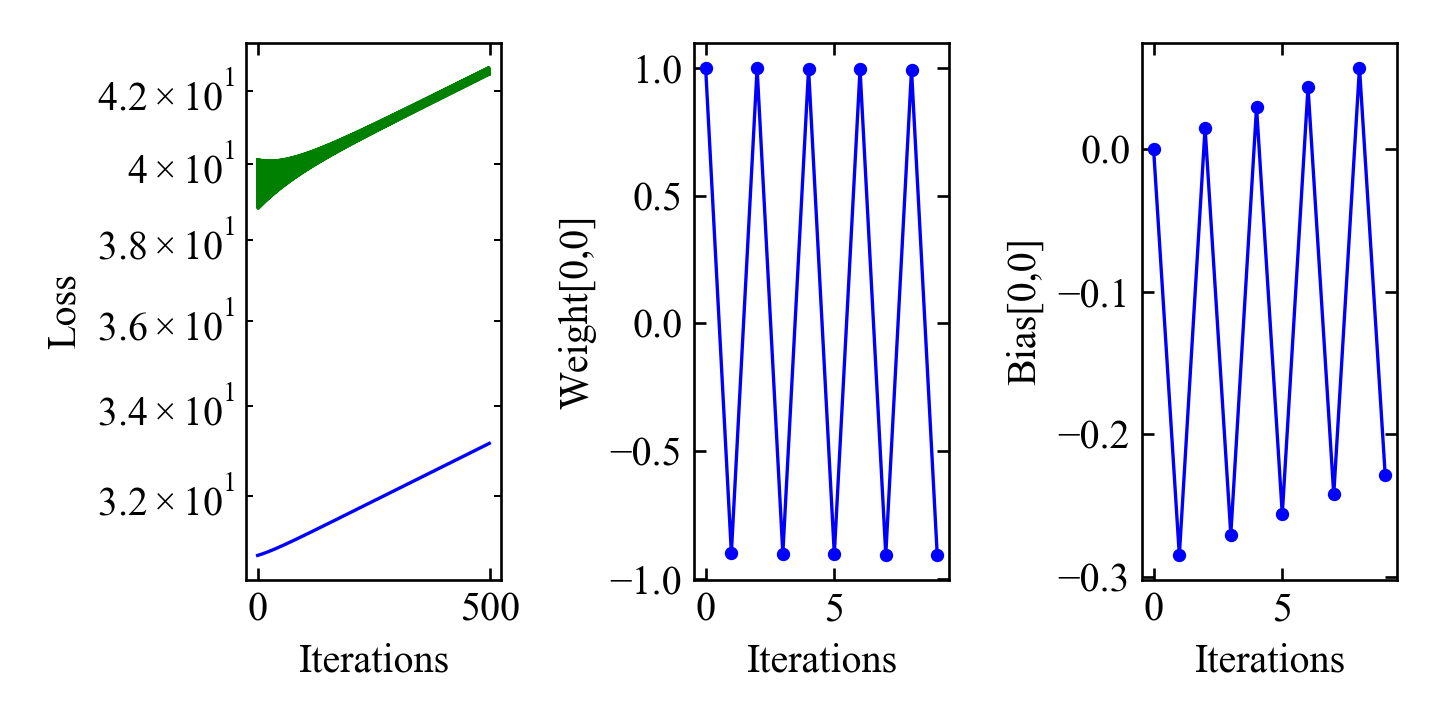

fitted parameters: [array([[-1.0170597]], dtype=float32), array([0.24235398], dtype=float32)]


In [183]:
learning_rate =0.03
iterations=500
nplot=10
net.apply(init_weights)

fig, ax = plt.subplots(figsize=(5,4))
#plt.cla()
ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
prediction, weightsv, lossv, lossvt=train(ax, net, learning_rate, iterations, x, y, xt, yt, nplot)

fig=plt.figure(figsize=(6,3))
ax=plt.subplot(131)
ax.set_yscale('log')
plt.plot(to_array(lossv))
plt.plot(to_array(lossvt))
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.subplot(132)

plt.plot(to_array2d(weightsv,0)[:10],'.-')
plt.xlabel("Iterations")
plt.ylabel("Weight[0,0]")
plt.subplot(133)
plt.plot(to_array2d(weightsv,1)[:10],'.-')
plt.ylabel("Bias[0,0]")
plt.xlabel("Iterations")

plt.tight_layout()
print("fitted parameters:", weightsv[-1]) 

In [113]:
#for para in net.parameters():
#    print(para.data)

## two-varaible linear regression: adding features

<IPython.core.display.Javascript object>


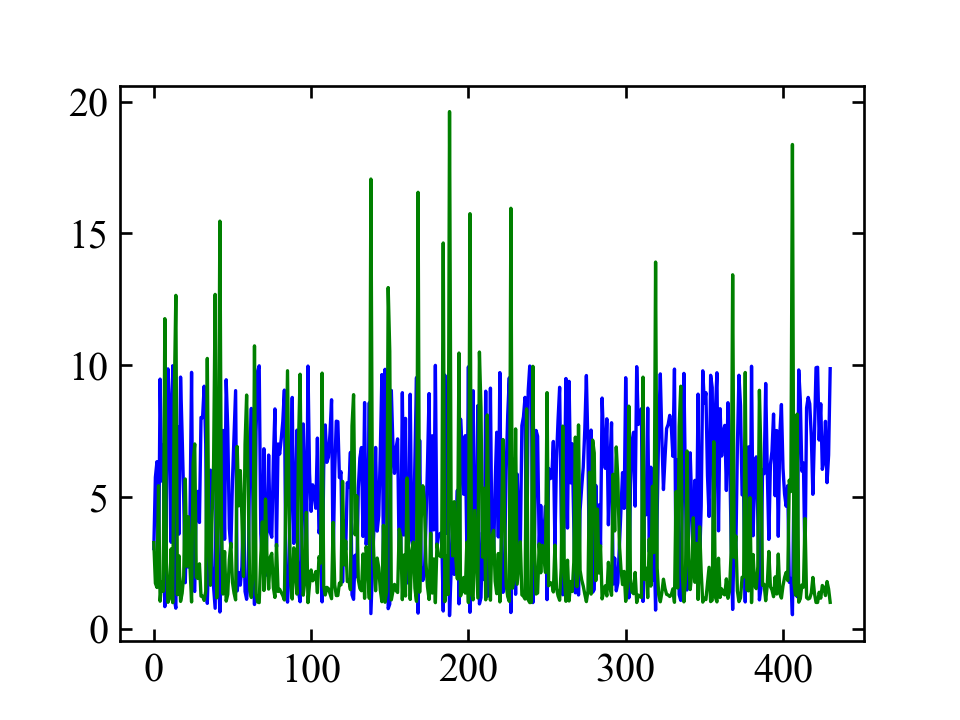

(431, 2)


In [242]:
plt.figure()
x2=np.array([x1,10.0/x1]).T #scale the features
print(x2.shape)
plt.plot(x2[:,0],'b')
plt.plot(x2[:,1],'g')

In [243]:
# torch can only train on Variable, so convert them to Variable
x=torch.from_numpy(x2[:nt,:]) #two feature
y=torch.from_numpy(y1[:nt].reshape(len(y1[:nt]),1)) #one output
x, y=Variable(x).float(),Variable(y).float()
print(x.shape, y.shape)
xt=torch.from_numpy(x2[nt:,:]) #two feature
yt=torch.from_numpy(y1[nt:].reshape(len(y1[nt:]),1)) #one output
xt, yt=Variable(xt).float(),Variable(yt).float()
print(xt.shape, yt.shape)

torch.Size([301, 2]) torch.Size([301, 1])
torch.Size([130, 2]) torch.Size([130, 1])


In [255]:
net = Net0(n_feature=2,n_output=1)     # define the network

<IPython.core.display.Javascript object>


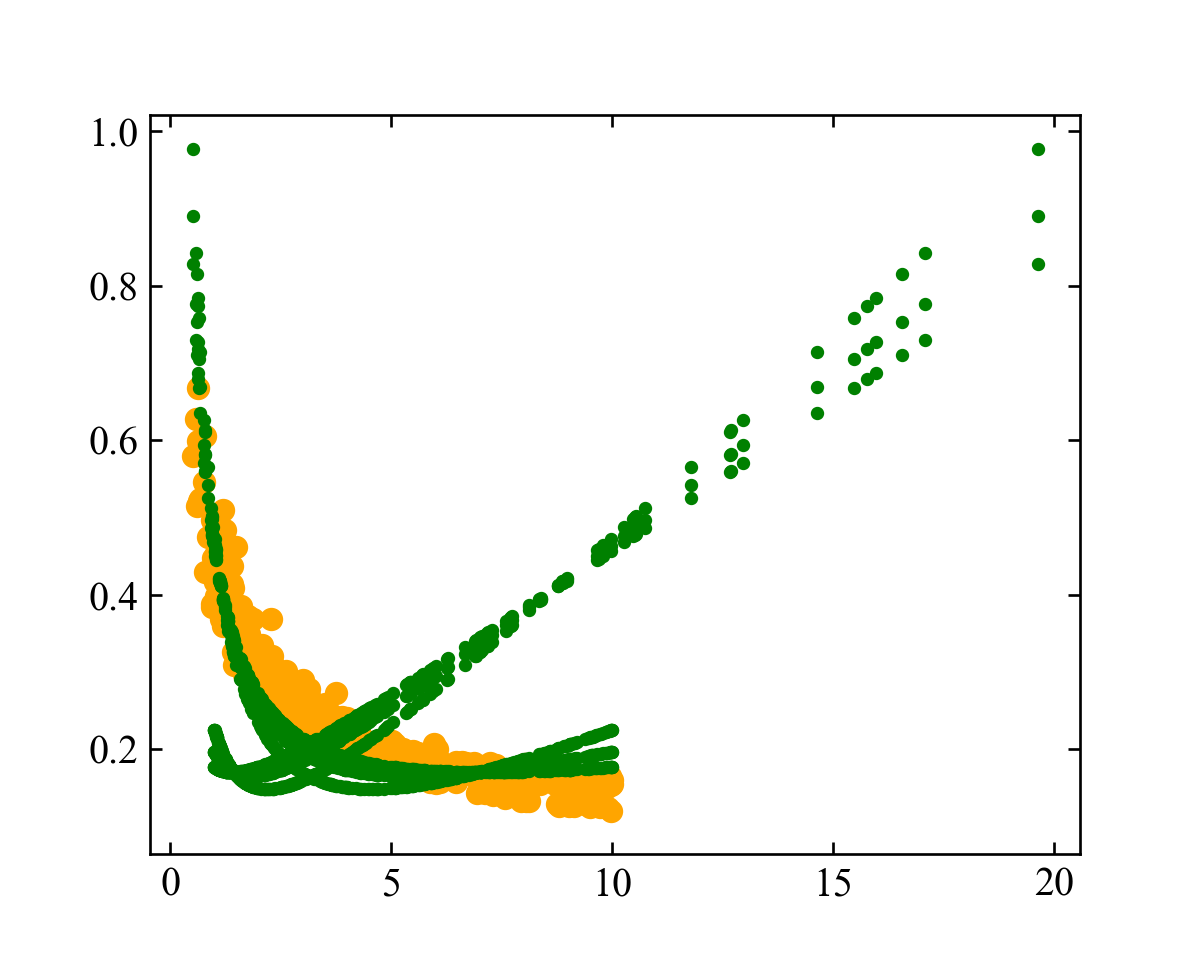

165 0.005344415549188852 0.004486081190407276
331 0.0029930812306702137 0.002642175881192088
497 0.0018409063341096044 0.0017355221789330244


<IPython.core.display.Javascript object>


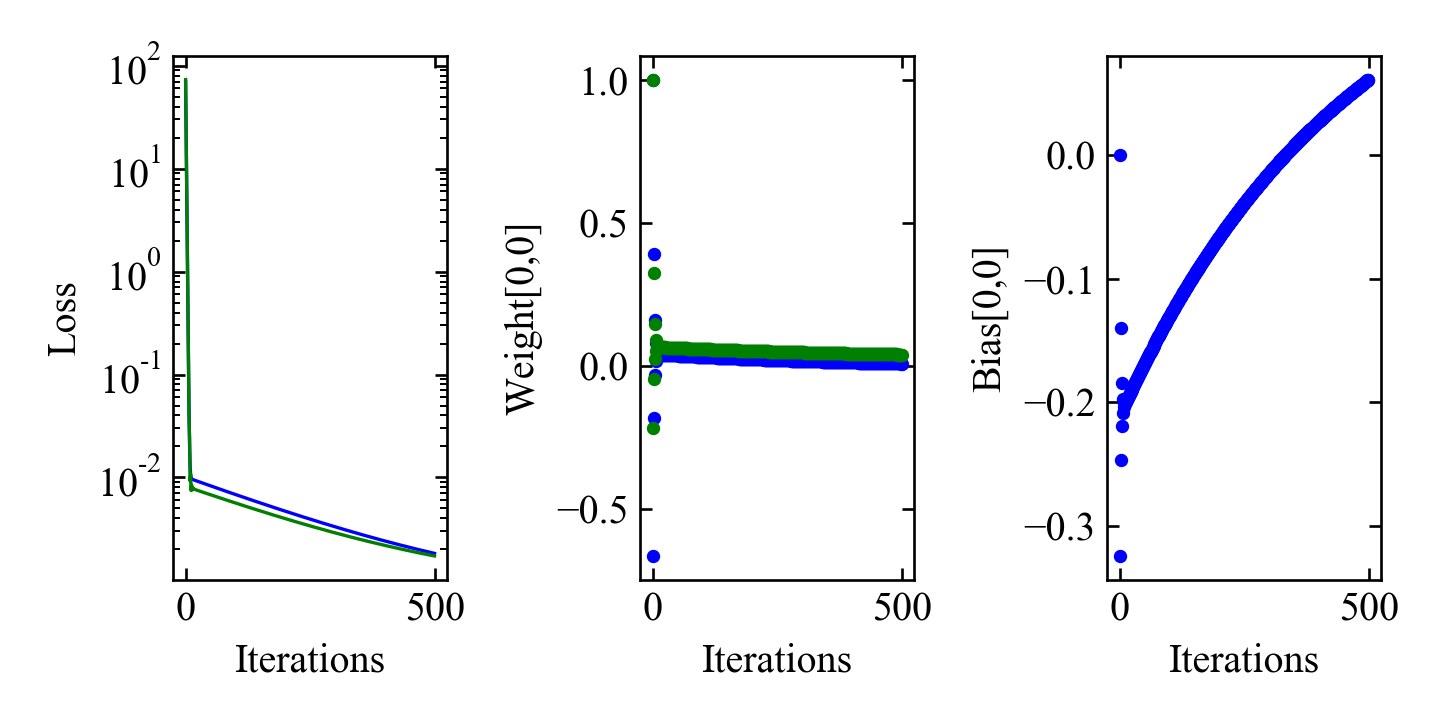

fitted parameters: [array([[0.00765738, 0.03888426]], dtype=float32), array([0.06094502], dtype=float32)]


In [256]:
learning_rate =0.02
iterations=500
nplot=3
net.apply(init_weights)

fig, ax = plt.subplots(figsize=(5,4))
#plt.cla()
ax.scatter(x.data.numpy()[:,0], y.data.numpy(), color = "orange")
prediction, weightsv, lossv, lossvt=train(ax, net, learning_rate, iterations, x, y, xt, yt, nplot)

fig=plt.figure(figsize=(6,3))
ax=plt.subplot(131)
ax.set_yscale('log')
plt.plot(to_array(lossv))
plt.plot(to_array(lossvt))
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.subplot(132)

plt.plot(to_array2d(weightsv,0),'.')
plt.xlabel("Iterations")
plt.ylabel("Weight[0,0]")
plt.subplot(133)
plt.plot(to_array2d(weightsv,1),'.')
plt.ylabel("Bias[0,0]")
plt.xlabel("Iterations")

plt.tight_layout()
print("fitted parameters:", weightsv[-1]) 

<IPython.core.display.Javascript object>


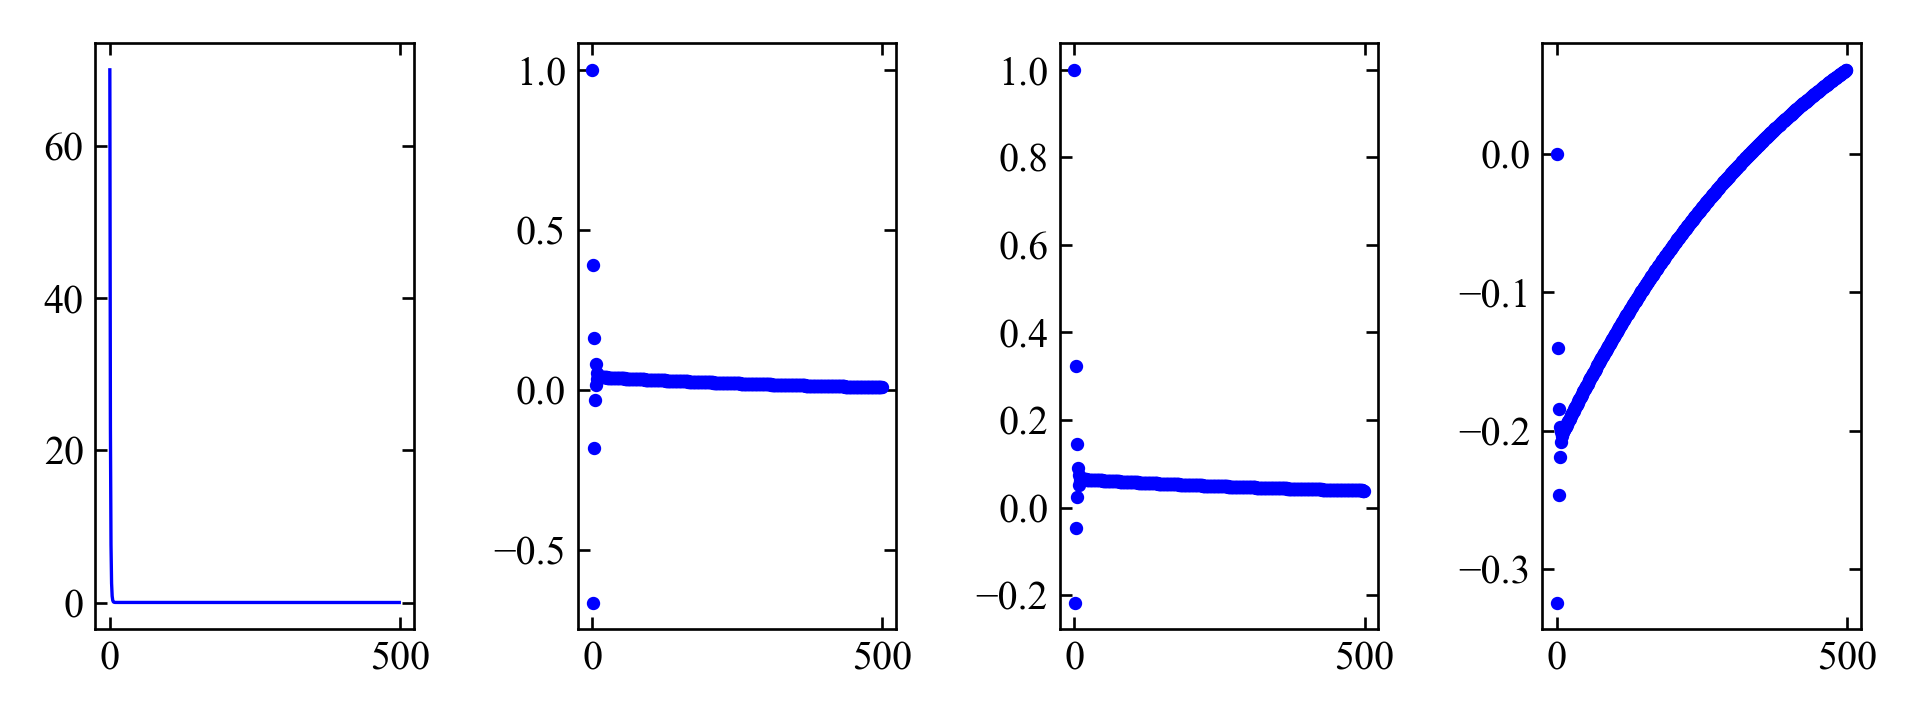

In [257]:
fig=plt.figure(figsize=(8,3))
plt.subplot(141)
plt.plot(lossv)
plt.subplot(142)
plt.plot(np.array([weightsv[t][0][0][0] for t in range(len(weightsv))]),'.')
plt.subplot(143)
plt.plot(np.array([weightsv[t][0][0][1] for t in range(len(weightsv))]),'.')
#plt.plot(weightsv[:,1],'.')
plt.subplot(144)
plt.plot(np.array([weightsv[t][1][0] for t in range(len(weightsv))]),'.')
plt.tight_layout()

<IPython.core.display.Javascript object>


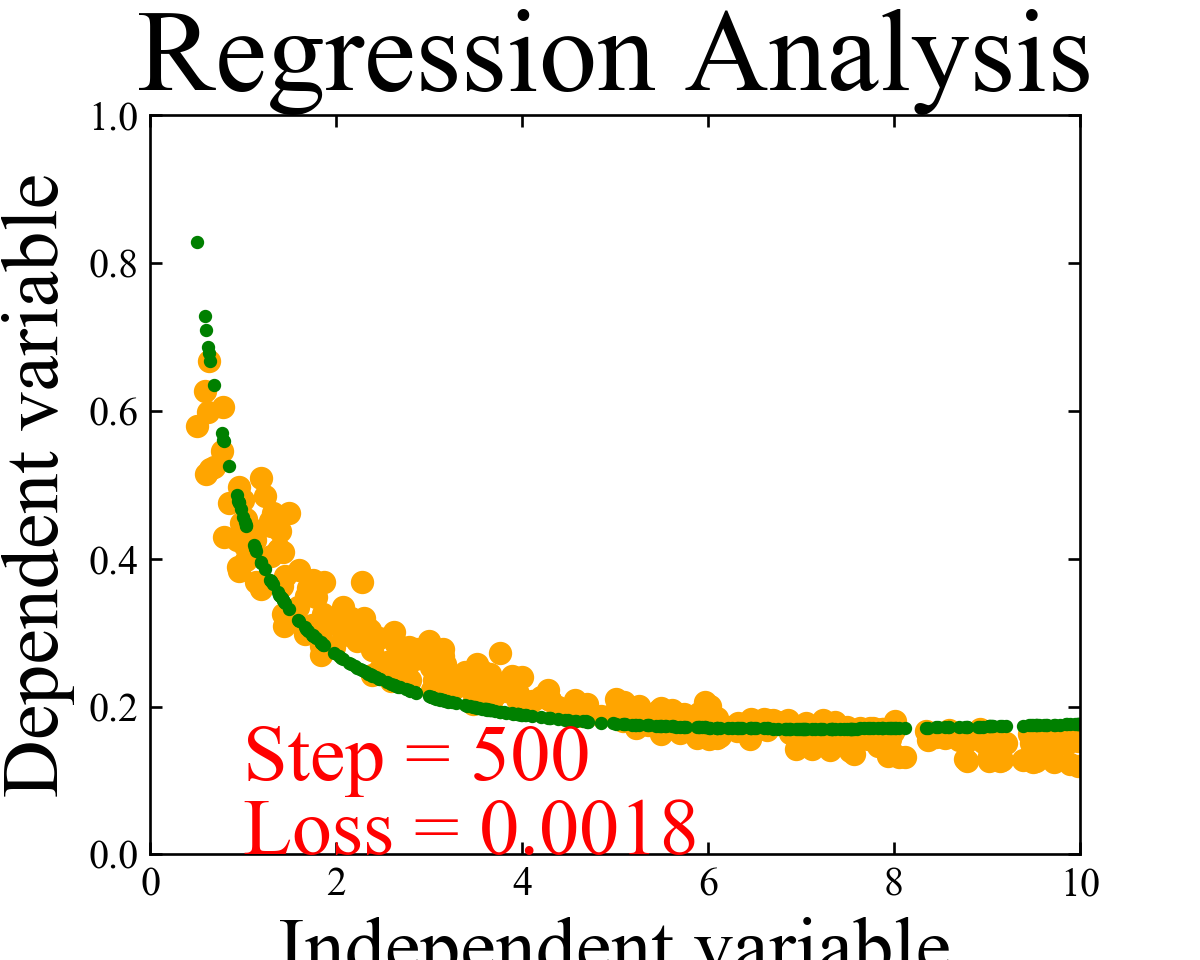

[]

In [258]:
fig, ax = plt.subplots(figsize=(5,4))
plt.cla()
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1)
ax.scatter(x.data.numpy()[:,0], y.data.numpy(), color = "orange")
ax.plot(x.data.numpy()[:,0], prediction.data.numpy(), 'g.', lw=3)
ax.text(1.0, 0.1, 'Step = %d' % iterations, fontdict={'size': 24, 'color':  'red'})
ax.text(1.0, 0, 'Loss = %.4f' % lossv[-1],
        fontdict={'size': 24, 'color':  'red'})
plt.plot()  